In [54]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../")

# Local imports
from src_experiment import get_new_data, get_new_path
from src_experiment import train_model_multiclass
from visualization import plot_training, plot_all_quantities
import geobin as gb
from src_experiment import EstimateQuantities1Run, AverageEstimates

In [3]:
# Experiment params
datasets = ["moons", "wbc", "wine", "hd", "car"]
noises = [0.0, 0.2, 0.4]
dropouts = [0.0, 0.1, 0.3, 0.5]
run_nrs = [1,2,3,4,5]

# Training

In [59]:
def plot_training_sweep_new(
    dataset,
    vary,
    values,
    *,
    dropout,
    noise,
    run_number,
    path_fn = get_new_path,  # Renamed from path_fn

):
    """
    Create a subplot figure sweeping over one parameter.

    Parameters
    ----------
    vary : str
        One of {"noise", "dropout", "run_number"}
    values : list
        Values of the parameter to vary
    dropout, noise, run_number :
        Fixed parameters (except the one being varied)
    get_new_path : callable
        Function get_new_path(dropout, noise, run_number,)
    """
    # Updated allowed vary quantities
    assert vary in {"noise", "dropout", "run_number", "dataset"}

    n = len(values)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5 * ncols, 4 * nrows),
        squeeze=False,
        sharex=True,
    )

    for idx, val in enumerate(values):
        r, c = divmod(idx, ncols)
        ax_loss = axes[r][c]

        # Set parameters
        params = dict(
            dataset=dataset,
            dropout=dropout,
            noise=noise,
            run_number=run_number,
        )
            
        params[vary] = val

        # Use the new path function name
        path = path_fn(**params)
        df = pd.read_csv(os.path.join(path, "run_summary.csv"))

        epochs = df.index.to_numpy()

        # Loss Plot
        ax_loss.plot(epochs, df["train_loss"], color="blue", linestyle="-", label="Train Loss")
        ax_loss.plot(epochs, df["test_loss"], color="blue", linestyle="--", label="Test Loss")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.set_title(f"{vary} = {val}", pad=15)
        ax_loss.grid(True, alpha=0.3)

        # Accuracy Plot (Twin Axis)
        ax_acc = ax_loss.twinx()
        ax_acc.plot(epochs, df["train_accuracy"], color="red", linestyle="-", label="Train Acc")
        ax_acc.plot(epochs, df["test_accuracy"], color="red", linestyle="--", label="Test Acc")
        ax_acc.set_ylabel("Accuracy")

        # Legend (combined from both axes)
        lines_1, labels_1 = ax_loss.get_legend_handles_labels()
        lines_2, labels_2 = ax_acc.get_legend_handles_labels()
        ax_loss.legend(
            lines_1 + lines_2,
            labels_1 + labels_2,
            loc="lower center",
            bbox_to_anchor=(0.5, 0.98),
            ncol=4,
            fontsize=8,
            frameon=False,
        )

    # Remove empty subplots
    for idx in range(n, nrows * ncols):
        r, c = divmod(idx, ncols)
        fig.delaxes(axes[r][c])

    def _format_fixed_params(dataset, vary, dropout, noise, run_number):
        params = {
            "dataset": dataset,
            "dropout": dropout,
            "noise": noise,
            "run_number": run_number,
        }


        fixed = {k: v for k, v in params.items() if k != vary}
        return ", ".join(f"{k}={v}" for k, v in fixed.items())

    main_title = f"Training sweep over {vary}"
    subtitle = f"Fixed parameters: {_format_fixed_params(dataset, vary, dropout, noise, run_number)}"
    fig.suptitle(main_title + "\n" + subtitle, fontsize=16, fontweight="bold")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Sweep across run numbers

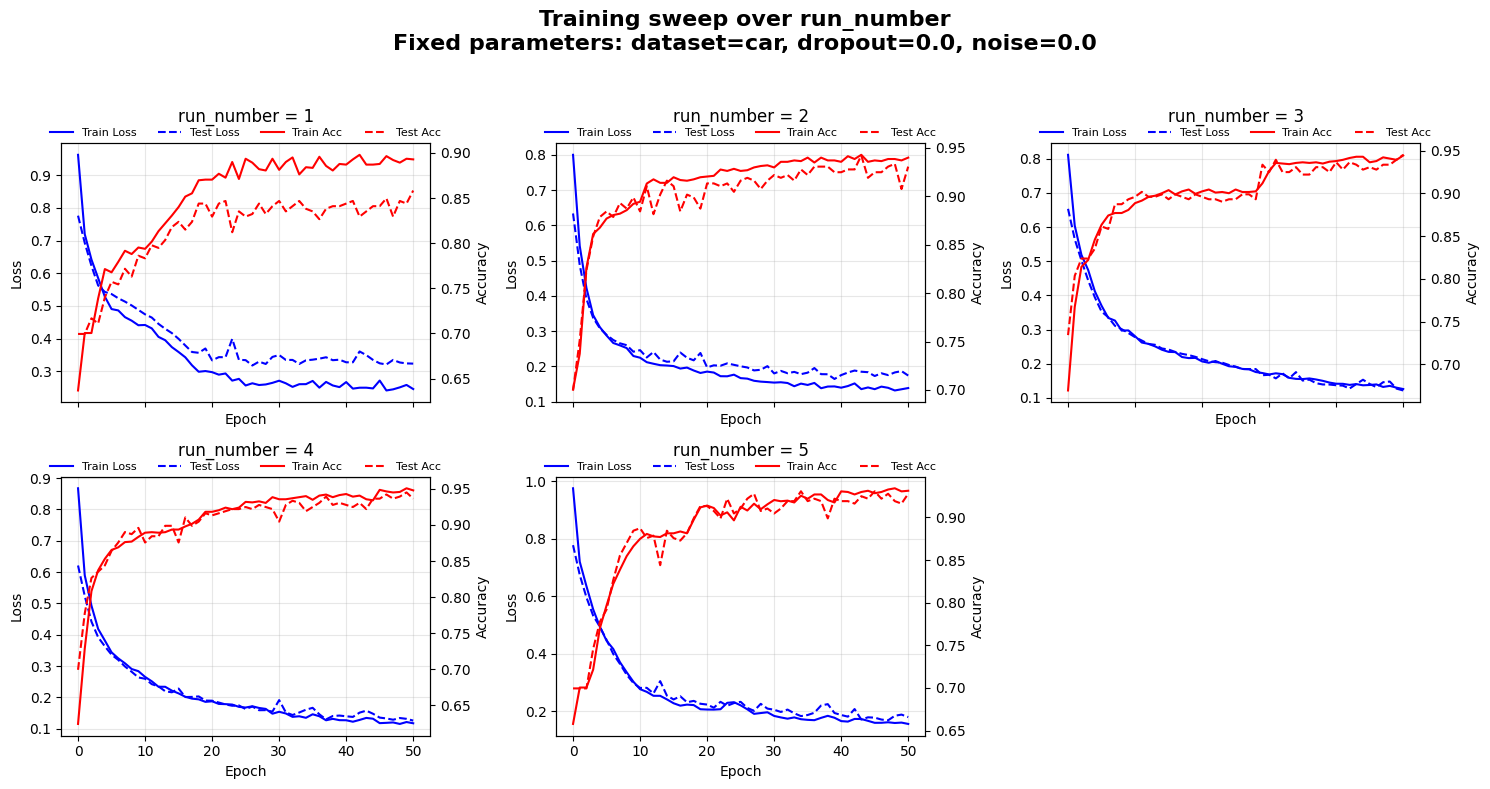

In [69]:
plot_training_sweep_new(
    "car",
    "run_number",
    run_nrs,
    dropout=0.0,
    noise= 0.0,
    run_number=0,
)

## Sweep across dropout

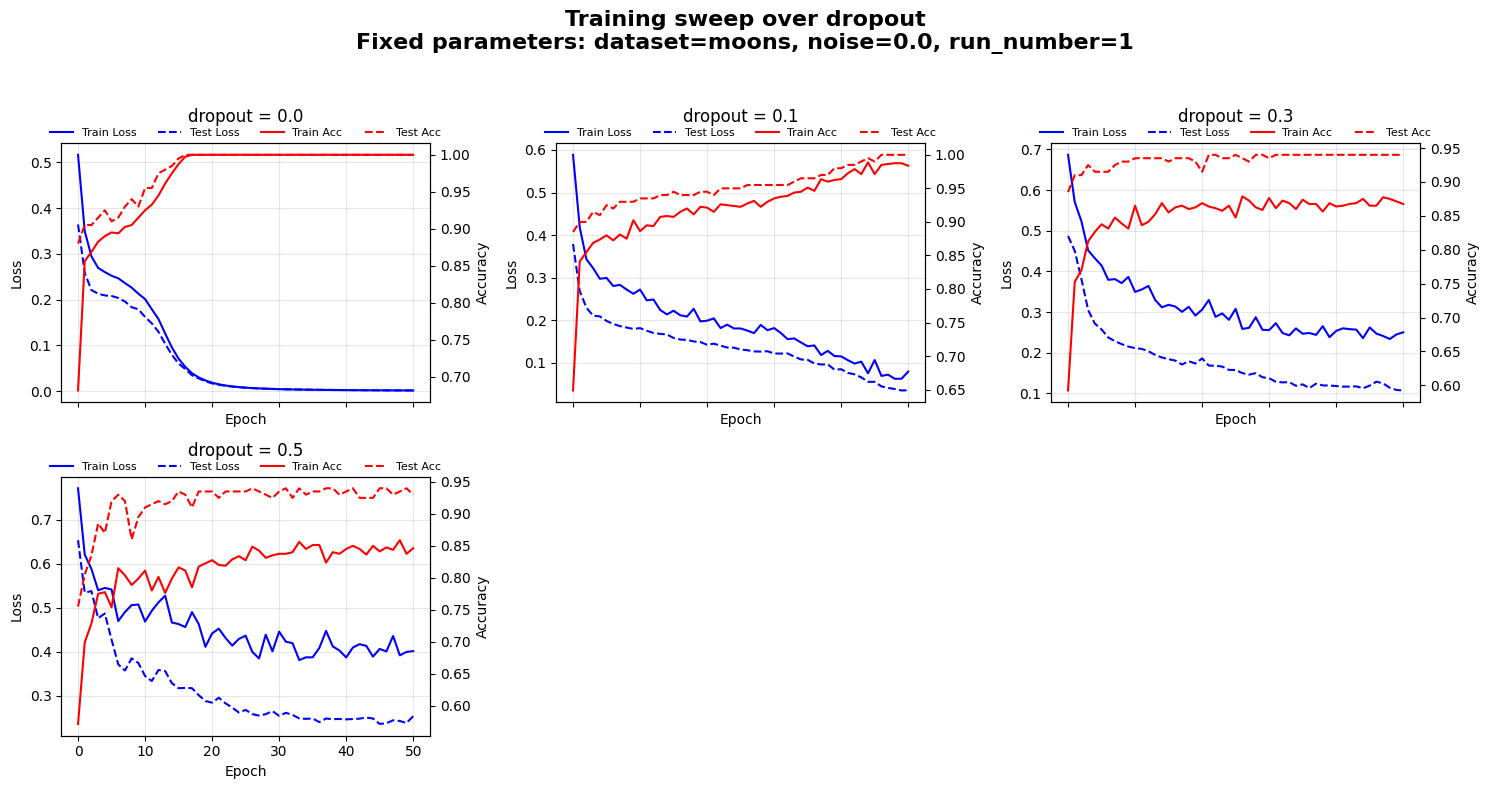

In [57]:
plot_training_sweep_new(
    "moons",
    "dropout",
    dropouts,
    dropout=0.0,
    noise= 0.0,
    run_number=1,
)

## Sweep across noise

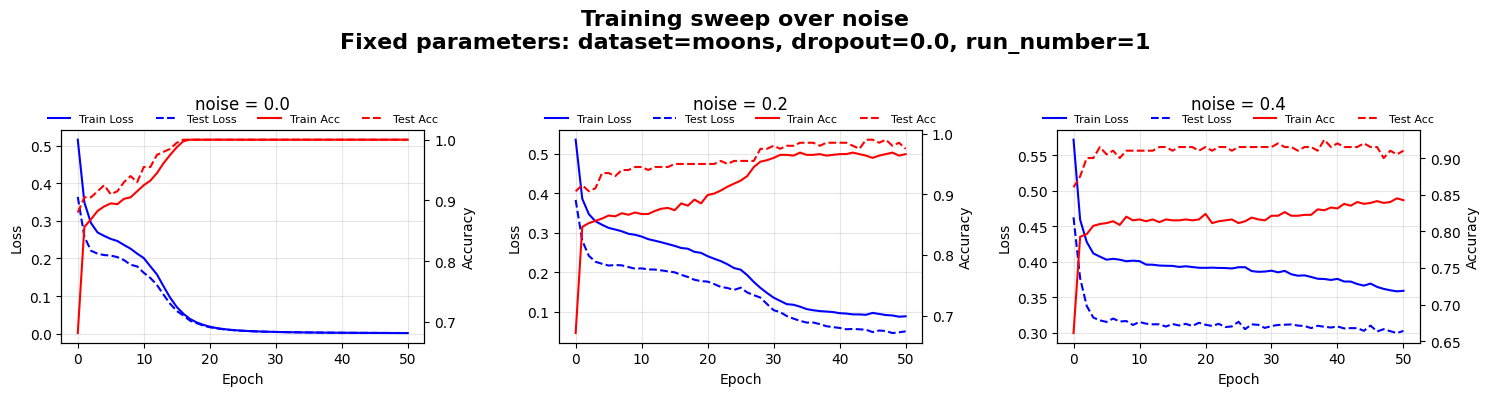

In [118]:
plot_training_sweep_new(
    "moons",
    "noise",
    noises,
    dropout=0.0,
    noise= 0.0,
    run_number=1,
)

# Sweep across datasets

In [ ]:
plot_training_sweep_new(
    "moons",
    "noise",
    noises,
    dropout=0.0,
    noise= 0.0,
    run_number=1,
)

# Estimates

## Single run

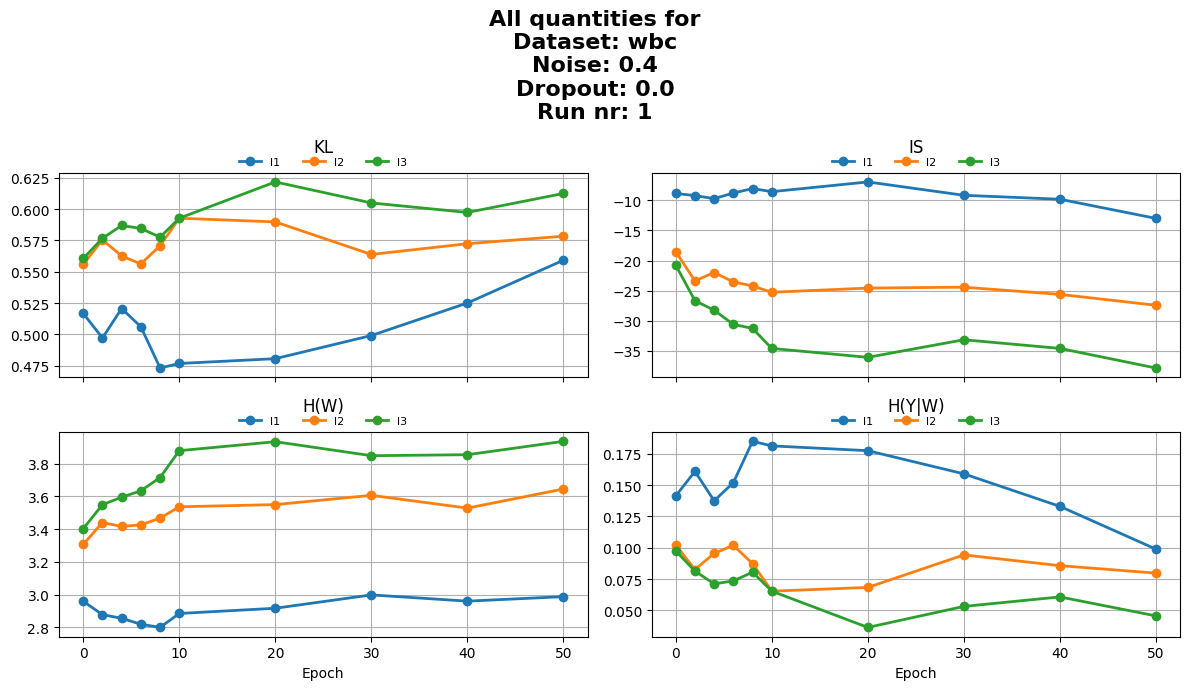

In [8]:
da = "wbc"
no = 0.4
dr = 0.0
ru = 1
Q = EstimateQuantities1Run(get_new_path(da,no,dr,ru))
plot_all_quantities(Q.get_estimates(), super_title = f"All quantities for\nDataset: {da}\nNoise: {no}\nDropout: {dr}\nRun nr: {ru}")

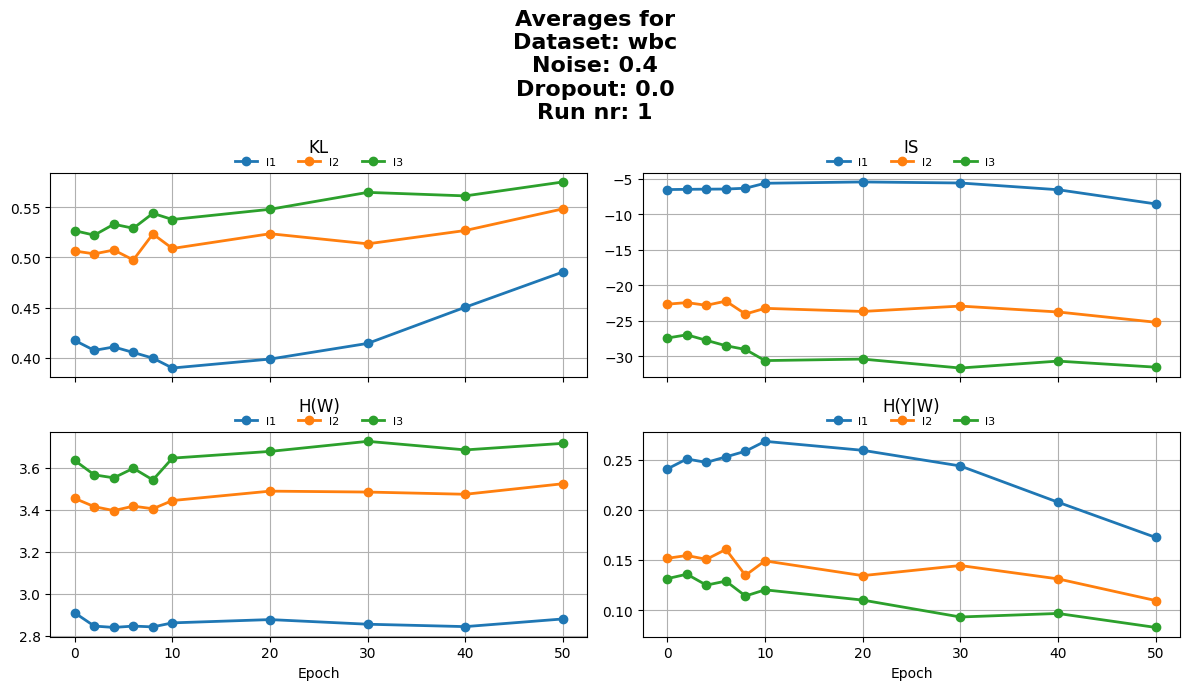

In [9]:
avgQ = AverageEstimates([get_new_path(da, no, dr, rn) for rn in run_nrs])
plot_all_quantities(avgQ.means, super_title=f"Averages for\nDataset: {da}\nNoise: {no}\nDropout: {dr}\nRun nr: {ru}")

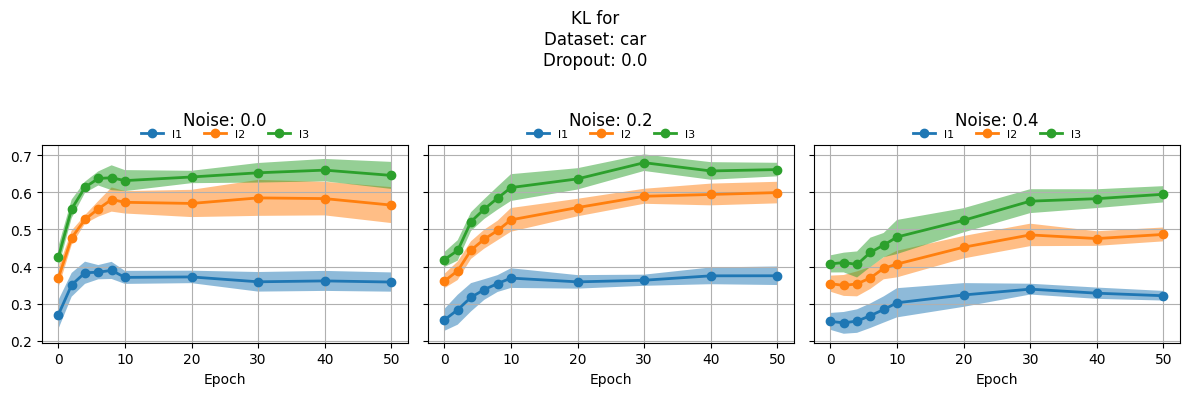

In [45]:
da = "car"
dr = 0.0
noises = [0.0, 0.2, 0.4]

average_KLs = {}
std_KLs = {}
for noise in noises:
    avgKL = AverageEstimates([get_new_path(da, noise, dr, rn) for rn in run_nrs])
    average_KLs[f"{noise}"] = avgKL.means["Kullback-Leibler"]
    std_KLs[f"{noise}"] = avgKL.stds["Kullback-Leibler"]
    
    
def plot_average_KL_together(frames, noises, stds=None, super_title="", **kwargs):
    r=1/2 # How much of the standard deviation should be shown?
    fig, axes = plt.subplots(ncols=len(noises), nrows=1, sharey=True, figsize=(4*len(noises),4))
    for ax, noise in zip(axes, noises):
        frame = frames[f"{noise}"] 
        for layer in frame.columns[1:-1]:
                if stds is not None:
                    std_frame = stds[f"{noise}"]
                    ax.fill_between(std_frame["epoch"], frame[layer]-r*std_frame[layer], frame[layer]+r*std_frame[layer], alpha=0.5)
                    ax.plot(frame["epoch"], frame[layer], ls="-", lw=2, marker="o", label=layer, **kwargs)
                else:
                    ax.plot(frame["epoch"], frame[layer], ls="-", lw=2, marker="o", label=layer, **kwargs)
                ax.set_title(f"Noise: {noise}", pad=15)
                ax.grid(True)
                ax.legend(loc="lower center",
                bbox_to_anchor=(0.5, 0.98),
                ncol=4,
                fontsize=8,
                frameon=False,)
                ax.set_xlabel("Epoch")
    fig.suptitle(super_title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
plot_average_KL_together(average_KLs, [0.0,0.2,0.4], stds=std_KLs, super_title=f"KL for\nDataset: {da}\nDropout: {dr}")

# Generalization gap

In [119]:
import torch
import torch.nn as nn
from src_experiment import NeuralNet
def find_single_gg(dataset, noise, dropout, run_number, epoch=50):
    # path = get_new_path(dataset, noise, dropout, run_number)
    # training_data = pd.read_csv(os.path.join(path, "run_summary.csv"))
    # test_acc = training_data["test_accuracy"]
    # train_acc = training_data["eval_train_accuracy"]
    
    # test_loss = training_data["test_loss"]
    # train_loss = training_data["eval_train_loss"]
    
    # test_acc_val = test_acc[average_from_epoch:].mean()
    # train_acc_val = train_acc[average_from_epoch:].mean()
    
    # test_loss_val = test_loss[average_from_epoch:].mean()
    # train_loss_val = train_loss[average_from_epoch:].mean()
    
    # Data
    train_data, test_data = get_new_data(dataset, noise=0.0)
    
    # Get shape of data
    x_batch, y_batch = next(iter(train_data))
    input_size = x_batch.shape[1]

    all_train_labels = torch.cat([y for _, y in train_data])
    num_classes = len(torch.unique(all_train_labels))
    
    # Model
    model = NeuralNet(
        input_size = input_size,
        hidden_sizes = [5,5,5],
        num_classes = num_classes,
    )
    state_dict = get_new_path(dataset, noise, dropout, run_number) / "state_dicts" / f"epoch{epoch}.pth"
    model.load_state_dict(torch.load(state_dict, weights_only=True))
    model.eval() # Set model to evaluation mode
    
    # Do a forward pass and record results
    loss_fn = nn.CrossEntropyLoss()

    
    # Eval on train data
    train_running_loss = 0.0
    train_num_correct = 0
    train_total_samples = 0
    with torch.no_grad():
        # Evaluate on training data (for GG-analysis)
        for x, y in train_data:
            x = x.float()
            y = y.long()
            
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            preds = y_hat.argmax(dim=1)
            
            train_running_loss += loss.item()
            train_num_correct += (preds == y).sum().item()
            train_total_samples += y.size(0)
    eval_train_loss = train_running_loss / len(train_data)
    eval_train_accuracy = train_num_correct / train_total_samples
        
    # Eval on test data
    test_running_loss = 0.0
    test_num_correct = 0
    test_total_samples = 0
    with torch.no_grad():
        for x, y in test_data:
            x = x.float()
            y = y.long()

            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            preds = y_hat.argmax(dim=1)
            
            test_running_loss += loss.item()
            test_num_correct += (preds == y).sum().item()
            test_total_samples += y.size(0)

    test_loss = test_running_loss / len(test_data)
    test_accuracy = test_num_correct / test_total_samples
    
    ## Generalization gap
    # gg = eval_train_accuracy - test_accuracy
    gg = test_accuracy
    return gg
    
def find_single_MI(dataset, noise, dropout, run_number, layer=-1, average_from_epoch=50):
    path = get_new_path(dataset, noise, dropout, run_number)
    Q = EstimateQuantities1Run(path)
    est = Q.get_estimates()["Kullback-Leibler"]
    mean_MI = est.loc[est["epoch"] >= average_from_epoch].iloc[:, layer].mean()
    return mean_MI
    

def get_gengap_data(
    dataset="moons",
):
    data_points = []
    
    for dropout in dropouts:
        for noise in noises:
            for run_nr in run_nrs:
                gg = find_single_gg(dataset, noise, dropout, run_nr)
                MI = find_single_MI(dataset, noise, dropout, run_nr)
                data_points.append((MI,gg))
    return data_points

In [112]:
def plot_gengap_points(data_points, title="Generalization Gap vs Penultimate MI"):
    """
    Plots a scatter of (penultimate MI, generalization gap) points.
    
    Args:
        data_points (list of tuples): Each tuple is (pen_mi, gg)
        title (str): Plot title
    """
    if not data_points:
        print("No data points to plot!")
        return
    
    # Unpack the tuples into two lists
    pen_mi_values, gg_values = zip(*data_points)
    
    plt.figure(figsize=(8,6))
    plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)
    
    plt.xlabel("Penultimate Layer Mutual Information")
    plt.ylabel("Generalization Gap")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Optional: annotate points (small example)
    # for i, (x, y) in enumerate(data_points):
    #     plt.text(x, y, str(i), fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_280681/1616776684.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


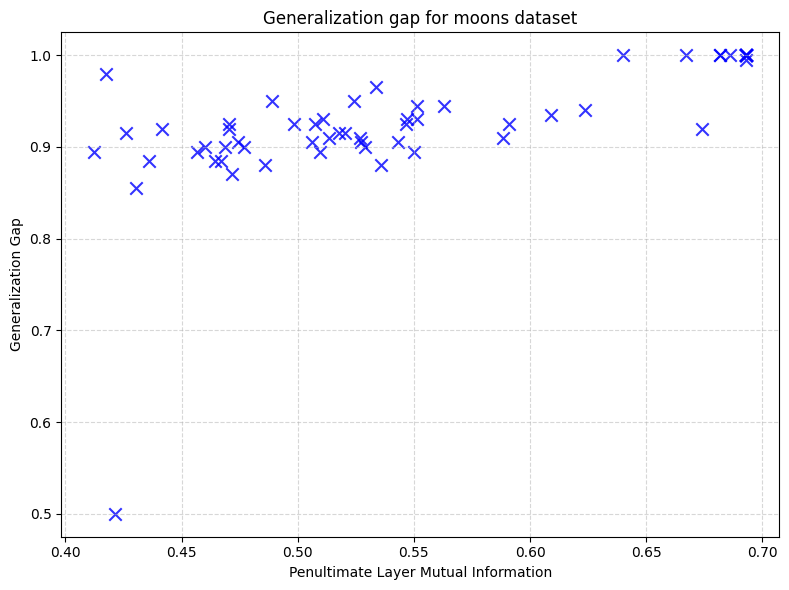

/tmp/ipykernel_280681/1616776684.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


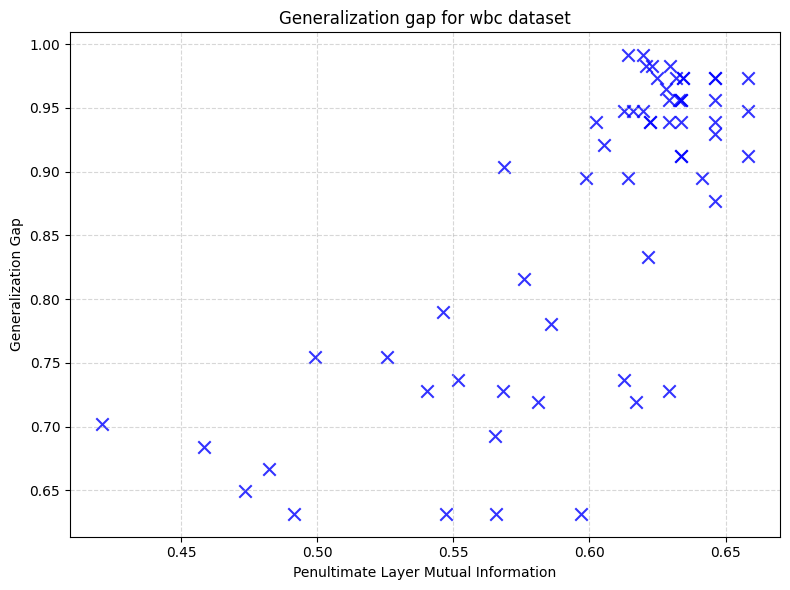

/tmp/ipykernel_280681/1616776684.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


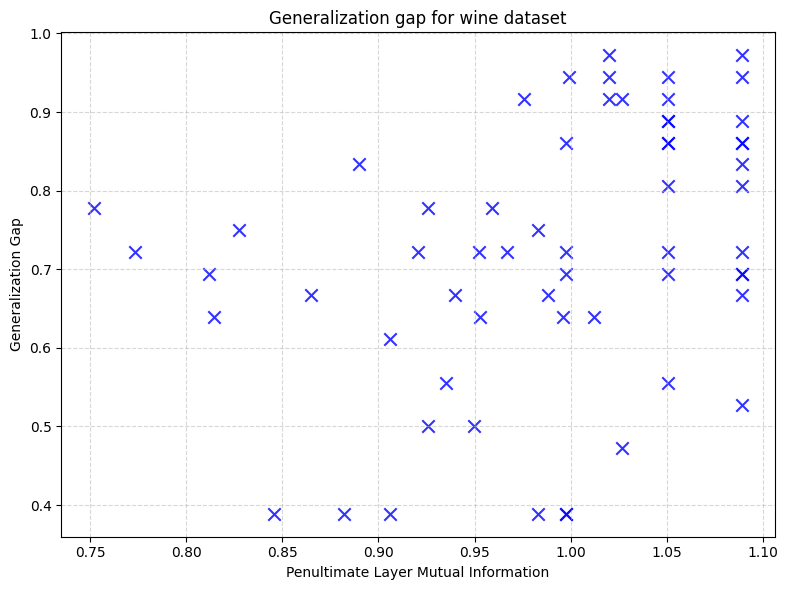

/tmp/ipykernel_280681/1616776684.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


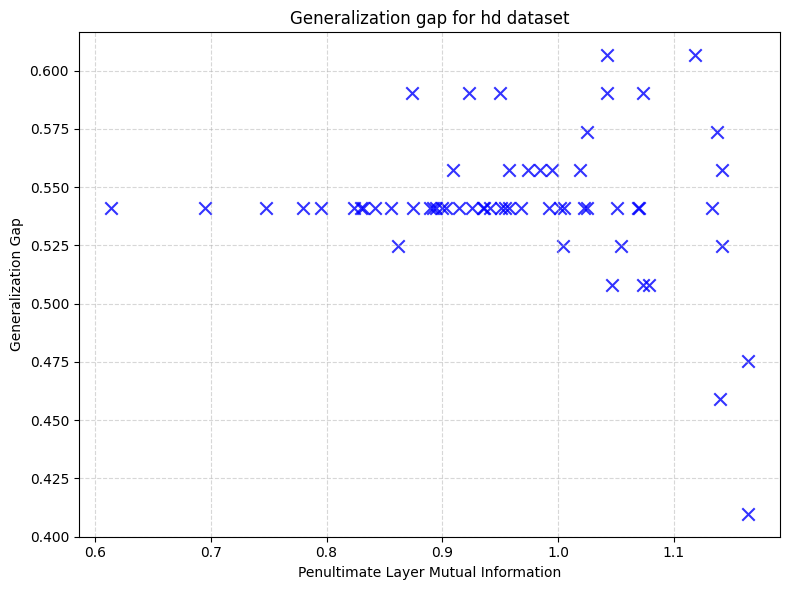

/tmp/ipykernel_280681/1616776684.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pen_mi_values, gg_values, marker="x", color='blue', edgecolor='k', s=80, alpha=0.8)


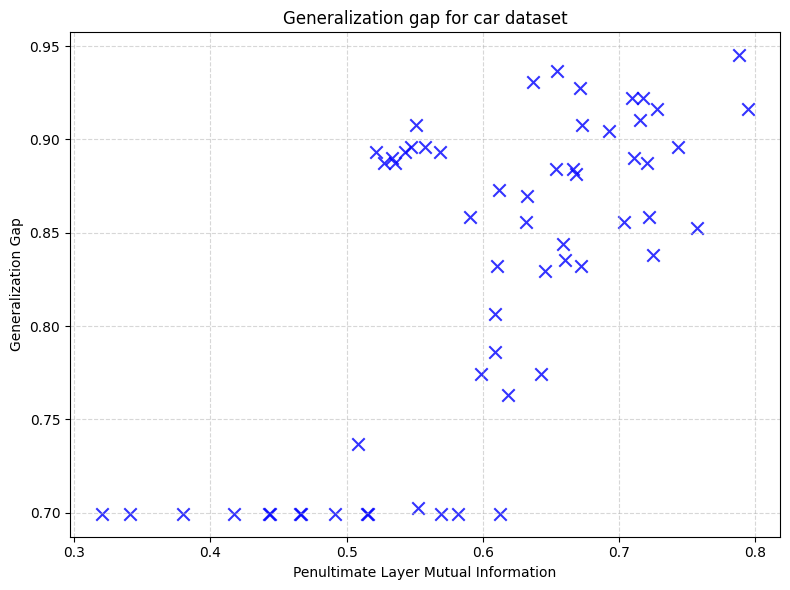

In [120]:
for ds in datasets:
    plot_gengap_points(get_gengap_data(ds), title=f"Generalization gap for {ds} dataset")